In [5]:
from pathlib import Path
import re
import numpy as np
from scipy.io import loadmat

def load_cwru_mat(mat_path: str | Path):
    mat_path = Path(mat_path)
    md = loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in md.keys() if not k.startswith("__")]

    def pick_suffix(suffix: str):
        for k in keys:
            if k.endswith(suffix):
                return k, md[k]
        return None, None

    k_de, de = pick_suffix("_DE_time")
    k_fe, fe = pick_suffix("_FE_time")
    k_rpm, rpm = pick_suffix("RPM")

    def to_1d(x):
        if x is None:
            return None
        x = np.asarray(x).reshape(-1)
        return x.astype(np.float64)

    return {
        "path": str(mat_path),
        "de_key": k_de,
        "fe_key": k_fe,
        "rpm_key": k_rpm,
        "DE": to_1d(de),
        "FE": to_1d(fe),
        "RPM": float(rpm) if rpm is not None else None,
        "keys": keys,
    }

def label_from_filename(stem: str):
    s = stem.upper()

    s = s.split("__", 1)[0]

    if "NORMAL" in s or "BASELINE" in s:
        return "normal"
    if s.startswith("IR"):
        return "inner_race"
    if s.startswith("OR"):
        return "outer_race"
    if s.startswith("B") or "BALL" in s:
        return "ball"
    return "unknown"

def load_folder(folder: str | Path):
    folder = Path(folder)
    mats = sorted(folder.glob("*.mat"))
    items = []
    for p in mats:
        d = load_cwru_mat(p)
        d["label"] = label_from_filename(p.stem) 
        items.append(d)
    return items

data = load_folder("./CWRU/12k_drive_end_fault_subset_labeled") 
print("loaded:", len(data))
print("example:", data[0]["path"], "DE_len=", None if data[0]["DE"] is None else len(data[0]["DE"]), "RPM=", data[0]["RPM"], "label=", data[0]["label"])

loaded: 3
example: CWRU/12k_drive_end_fault_subset_labeled/B007_0__118.mat DE_len= 122571 RPM= 1796.0 label= ball


# RMS

관심있는 시간($T$)동안 파형의 제곱 평균에 제곱근을 씌운 값으로, 특정시간($T$) 동안의 진폭의 평균 크기를 나타냄.

$$u_{rms} = \sqrt{\frac{1}{T}\int_{0}^{T}u^2(t)dt}$$

```python
rms = np.sqrt(np.mean(x**2))
```

In [6]:
import numpy as np
from scipy import signal

def preprocess(x: np.ndarray, detrend=True, normalize=True):
    x = np.asarray(x, dtype=np.float64)
    if detrend:
        x = signal.detrend(x, type="constant") 
    if normalize:
        std = x.std() + 1e-12
        x = x / std
    return x

def segment(x: np.ndarray, fs: float, win_sec=1.0, hop_sec=0.5):
    n = int(win_sec * fs)
    hop = int(hop_sec * fs)
    segs = []
    for i in range(0, len(x) - n + 1, hop):
        segs.append(x[i:i+n])
    return np.stack(segs, axis=0) if segs else np.empty((0, n))

def time_features(x: np.ndarray):
    x = np.asarray(x)
    rms = np.sqrt(np.mean(x**2))
    peak = np.max(np.abs(x))
    cf = peak / (rms + 1e-12) 
    kurt = np.mean((x - x.mean())**4) / ((np.var(x) + 1e-12)**2) 
    return {"rms": float(rms), "peak": float(peak), "crest_factor": float(cf), "kurtosis": float(kurt)}

fs = 12000
x = data[0]["DE"]
x = preprocess(x)

segs = segment(x, fs, win_sec=1.0, hop_sec=0.5)
print("segments:", segs.shape)

feat0 = time_features(segs[0])
print("time features:", feat0)

segments: (19, 12000)
time features: {'rms': 0.9912352358482627, 'peak': 3.8442446448657193, 'crest_factor': 3.878236472871223, 'kurtosis': 2.9645060586987}


Total segment-rows: 57


/tmp/ipykernel_1210852/739386953.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


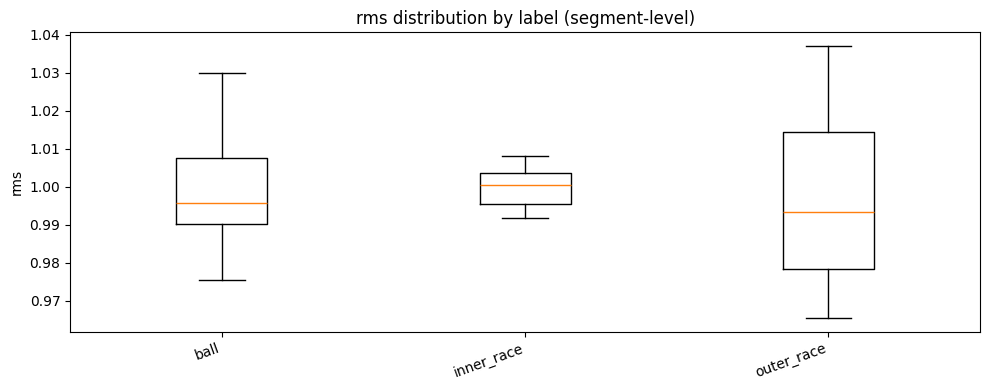

/tmp/ipykernel_1210852/739386953.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


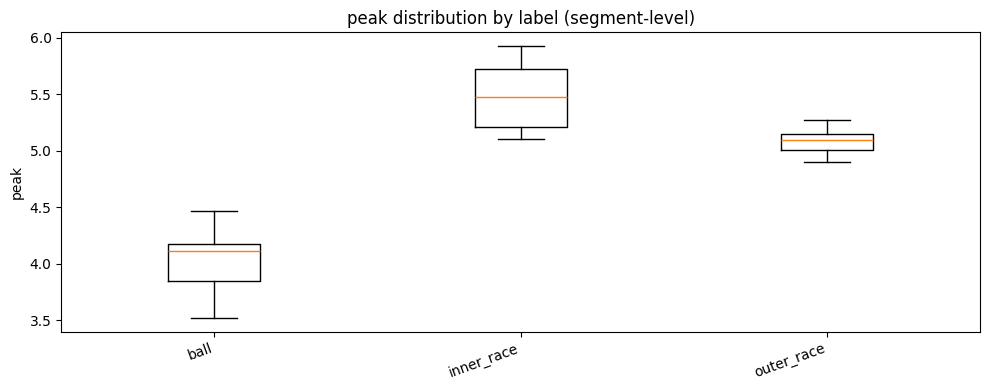

/tmp/ipykernel_1210852/739386953.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


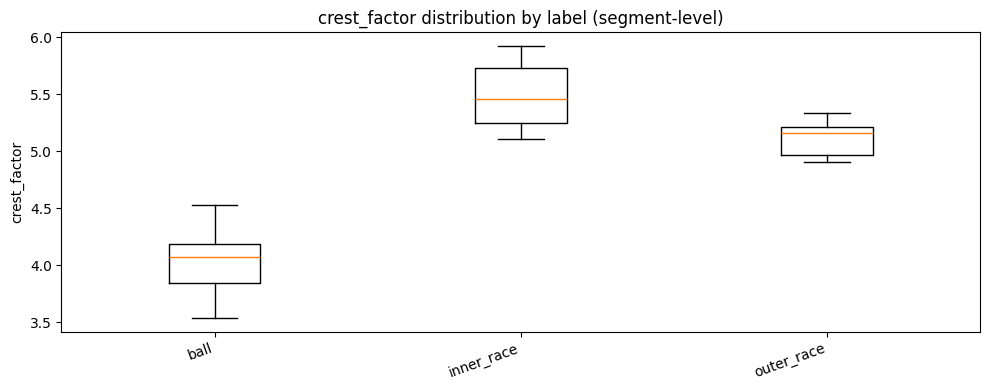

/tmp/ipykernel_1210852/739386953.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


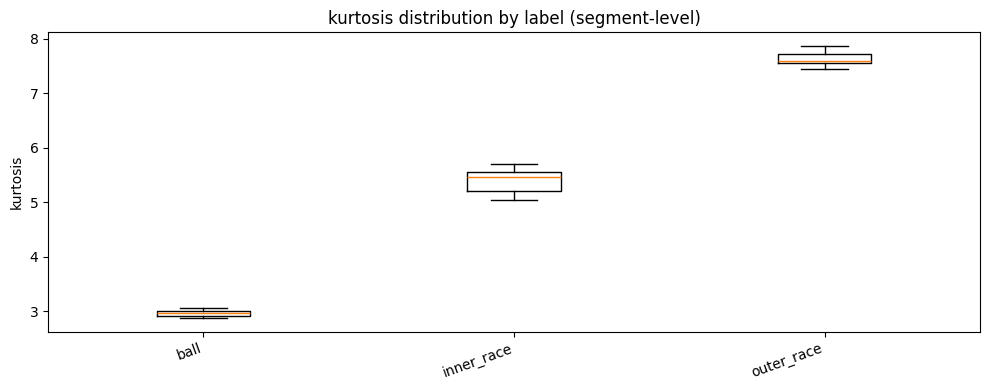

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def build_feature_rows(data, fs, win_sec=1.0, hop_sec=0.5, channel="DE"):
    """
    각 파일을 세그먼트로 나누고, 세그먼트별 특징값을 row로 쌓아 반환
    rows: list[dict] (file, label, seg_idx, rms, peak, crest_factor, kurtosis)
    """
    rows = []
    for i, item in enumerate(data):
        x = item.get(channel, None)
        if x is None:
            continue

        x = preprocess(x)
        segs = segment(x, fs, win_sec=win_sec, hop_sec=hop_sec)
        if segs.shape[0] == 0:
            continue

        for sidx in range(segs.shape[0]):
            feats = time_features(segs[sidx])
            rows.append({
                "file_idx": i,
                "file": item.get("path", f"file_{i}"),
                "label": item.get("label", "unknown"),
                "seg_idx": sidx,
                **feats
            })
    return rows

def boxplot_by_label(rows, feature, title=None, exclude_unknown=False):
    labels = sorted({r["label"] for r in rows if (not exclude_unknown) or r["label"] != "unknown"})
    groups = []
    for lab in labels:
        vals = [r[feature] for r in rows if r["label"] == lab]
        groups.append(vals)

    plt.figure(figsize=(10, 4))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel(feature)
    plt.title(title or f"{feature} distribution by label (segment-level)")
    plt.tight_layout()
    plt.show()

fs = 12000
rows = build_feature_rows(data, fs, win_sec=1.0, hop_sec=0.5, channel="DE")
print("Total segment-rows:", len(rows))

for feat in ["rms", "peak", "crest_factor", "kurtosis"]:
    boxplot_by_label(rows, feat, exclude_unknown=False)